# Análisis y modelado de predicción de compra en un sitio web

**Nombre:** Jorge Galeano Maté

**Información sobre los datos:**

- `Revenue`: target a predecir. Indica si el cliente compró en la web (1) o no (0).

- `Administrative`, `Administrative Duration`, `Informational`, `Informational Duration`: número de diferentes tipos de páginas visitadas por el visitante en esa sesión y el tiempo total dedicado a cada una de estas categorías de páginas.

- `Bounce Rates`: porcentaje de visitantes que entran en el sitio web desde esa página y luego salen ("rebote") sin activar ninguna otra solicitud al servidor de análisis durante esa sesión.

- `Exit Rates`: porcentaje de veces que dicha página fue la última visitada durante la sesión.

- `Page Values`: media de veces que se visita dicha página web antes de completar una transacción de comercio electrónico.

- `Special Day`: cercanía de la fecha de visita del sitio a un día especial específico (por ejemplo, el Día de la Madre, el Día de San Valentín). Toma valores entre 0 y 1, siendo 1 cuando la fecha de visita es muy cercana al día especial en cuestión.

- El conjunto de datos también incluye el sistema operativo, el navegador, la
región, el tipo de tráfico, el tipo de visitante como visitante que regresa o como
nuevo visitante, un valor booleano que indica si la fecha de la visita es de fin de
semana, y el mes del año.

**Instrucciones:**

1. Realizar un análisis exploratorio (EDA).
2. Realizar un preprocesamiento de los datos (de cara a entrenar los modelos).
3. Ajustar y evaluar distintos modelos:
    - KNN.
    - Un modelo basado en árboles.
    - Red neuronal MLP con scikit-learn.
4. Obtener métricas sobre el modelo elegido (escoger umbral donde recall y precision sean similares). Representar curva de ganancia acumulada.
---

En primer lugar, importamos las librerías necesarias.

In [ ]:
# Manejo de datos.
import pandas as pd
import numpy as np

# Visualización.
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado.
from sklearn.model_selection import train_test_split
import optuna
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from kds.metrics import plot_cumulative_gain
import pickle

# Variables de entorno y funciones
from dotenv import load_dotenv
import os
SYS_PATH = os.getenv('SYS_PATH')
import sys
load_dotenv()
sys.path.append(SYS_PATH) # Añadir ruta absoluta a carpeta del proyecto en archivo .env
from utils.model_functions import calcular_ratio_correlacion, definir_pipeline, predecir_evaluar_auc, curva_roc, umbral_metricas

# Otros.
import warnings
from sklearn.exceptions import ConvergenceWarning

## 1. EDA y limpieza de datos

Iniciamos el análisis exploratorio, cargamos los datos y visualizamos las primeras filas.

In [2]:
datos = pd.read_csv('./datos/online_shoppers_intention.csv')

datos.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Para poder hacer un análisis correctamente, comprobamos que las columnas sean del tipo correcto. De esta manera, podemos explorar los datos numéricos y categóricos de la forma adecuada.

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Como están correctamente asignados, realizamos un `describe()` para ver las estadísticas de los datos numéricos y de los datos categóricos y booleanos.

In [4]:
datos.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [5]:
datos.describe(exclude='number')

,Month,VisitorType,Weekend,Revenue
count,12330,12330,12330,12330
unique,10,3,2,2
top,May,Returning_Visitor,False,False
freq,3364,10551,9462,10422


Podemos comprobar los valores dentro de los que ronda cada variable. En el caso de las categóricas, se observa que el mes en el que más se visita la web es en mayo, y que los visitantes que más acceden son visitantes que ya habían visitado la web anteriormente.

Como podemos observar, hay columnas que tienen valores nulos y columnas que tienen valores erróneos (como, por ejemplo, el `Administrative Duration` que tiene valores negativos). Para entender mejor esos datos, analizamos los valores que toman las visitas a la web cuando la duración es -1 y cuando los valores son nulos.

In [6]:
datos.isnull().any(axis=1).sum()

np.int64(14)

In [7]:
datos[datos.isnull().any(axis=1)]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,False,False
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,False,False
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,False,False
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,False,False
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,True,False
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,6,1,Returning_Visitor,True,False
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,False,False
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,2,3,Returning_Visitor,False,False


Como solamente hay 14 filas con valores nulos, y además coinciden los nulos de las diferentes columnas, podemos eliminarlas, ya que representan una ínfima parte del total y no nos aportan información útil.

In [8]:
datos = datos.dropna()

In [9]:
print(datos[datos['Administrative_Duration'] == -1]['Administrative'].value_counts())
print(datos[datos['Informational_Duration'] == -1]['Informational'].value_counts())
print(datos[datos['ProductRelated_Duration'] == -1]['ProductRelated'].value_counts())

Administrative
0.0    31
1.0     2
Name: count, dtype: int64
Informational
0.0    33
Name: count, dtype: int64
ProductRelated
1.0    33
Name: count, dtype: int64


En el caso de los valores negativos, en vez de eliminar las filas, podemos modificar los valores.

Los valores negativos que correspondan con 0 visitas a la sección de la web correspondiente los sustituimos por 0; y los que correspondan con una visita a la sección de la web, los sustituimos por la mediana de la duración de esa sección. Es decir, si por ejemplo el valor negativo de `Administrative Duration` corresponde a 0 visitas, lo sustituimos por 0; y si corresponde a 1 visita, lo sustituimos por la mediana.

Escogemos la mediana en vez de la media porque hemos observado que hay una gran variación en los datos, y la mediana es más robusta a los valores atípicos.

In [10]:
datos.loc[(datos['Administrative_Duration'] == -1) &
          (datos['Administrative'] == 0), 'Administrative_Duration'] = 0

datos.loc[(datos['Administrative_Duration'] == -1) &
          (datos['Administrative'] == 1), 'Administrative_Duration'] = datos['Administrative_Duration'].median()

datos.loc[datos['Informational_Duration'] == -1, 'Informational_Duration'] = 0

datos.loc[datos['ProductRelated_Duration'] == -1, 'ProductRelated_Duration'] = datos['ProductRelated_Duration'].median()

Comprobamos los valores únicos de las variables categóricas:

In [11]:
for col in datos.select_dtypes(include='object').columns:
    print(f'{col}:', datos[col].unique())

Month: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
VisitorType: ['Returning_Visitor' 'New_Visitor' 'Other']


Como observamos, no hay ningún dato repetido o anómalo en esas columnas.

Continuando con el análisis exploratorio, analizamos si hay valores atípicos en las variables numéricas. Usamos boxplots, útiles para visualizar la distribución de los datos:

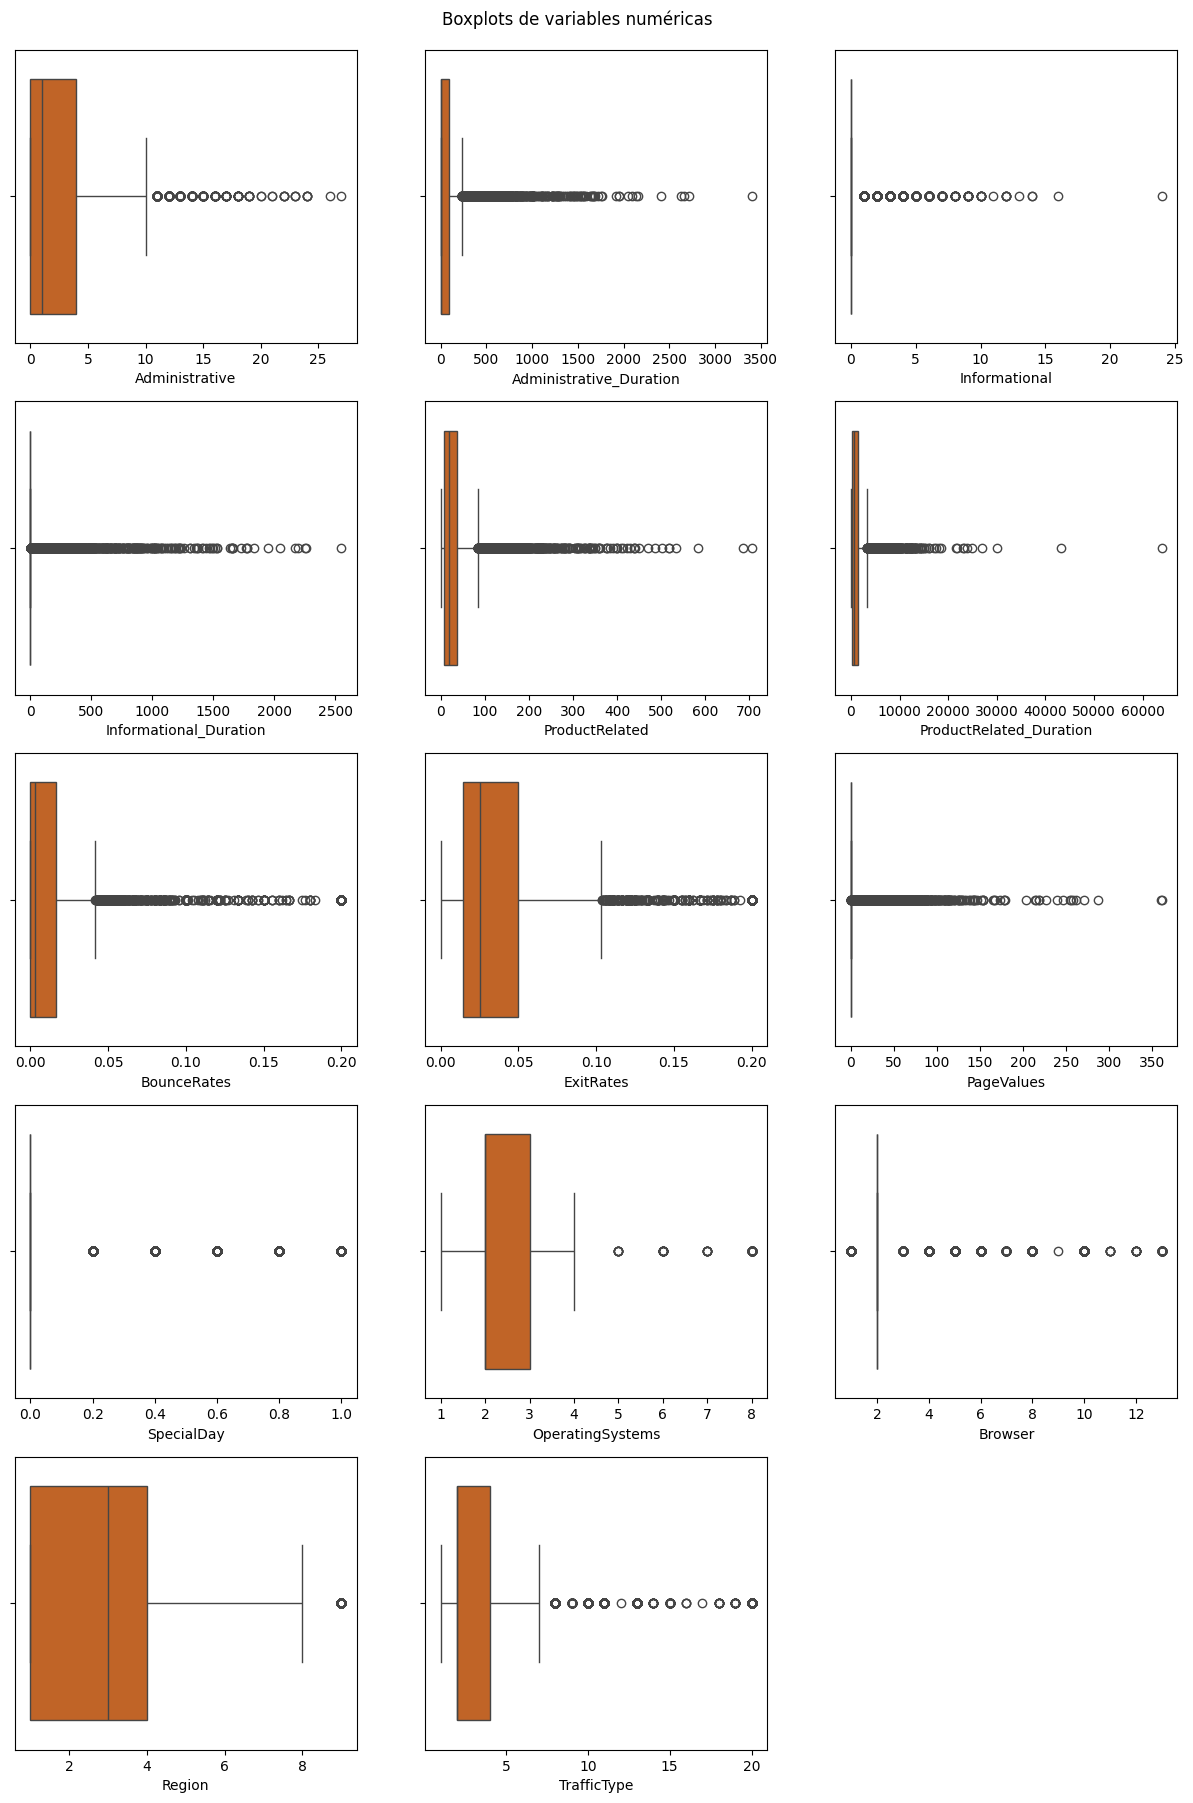

In [12]:
columnas_numericas = datos.select_dtypes(include='number').columns

plt.figure(figsize=(15,20))
plt.suptitle('Boxplots de variables numéricas')

for i in range(len(columnas_numericas)):
    plt.subplot(5, 3, i+1)
    sns.boxplot(datos, x=columnas_numericas[i], color='#d95f0e')

plt.subplots_adjust(top=0.96)
plt.show()

Los gráficos tipo boxplot nos representan la distribución de los datos de las variables numéricas, indicando con puntos los outliers.

Podemos comprobar que hay una gran cantidad de valores atípicos en todas las variables, aunque es lógico en muchas de ellas. Por ejemplo, es lógico que la mayoría de la gente use el mismo navegador (posiblemente Chrome) o que la mayoría de días no estén cerca de un día especial.

En el caso de las duraciones, es de suponer que el número corresponde a segundos (ya que sería ilógico pensar que la duración de las visitas en cada sesión sean de varias horas), por lo que no es raro encontrar valores atípicos que superan la hora de duración. En cambio, en el caso concreto de la duración de la sección relacionada con productos, es raro que haya valores que superen varias horas (hay valores de más de 5 horas de duración). Posiblemente se deba a errores de registro o al uso de bots automatizados que navegan por la página. Por tanto, se decide imputar los valores superiores a 10.000 segundos (aproximadamente 2 horas y 45 minutos) cambiándolos a 10.000 segundos.

In [13]:
datos.loc[datos['ProductRelated_Duration'] > 10000, 'ProductRelated_Duration'] = 10000

Revisamos qué porcentaje suponen los outliers en las columnas:

In [14]:
for col in columnas_numericas:
    # Obtenemos rango intercuartílico.
    IQR = datos[col].quantile(0.75) - datos[col].quantile(0.25)
    # Calculamos porcentaje de outliers de la columna (datos que salgan de +-1.5 el IQR).
    porcentaje_outliers = datos[(datos[col] > 1.5 * IQR) | (datos[col] < -1.5 * IQR)][col].count() / datos[col].count()

    print(f'{col}: {round(porcentaje_outliers * 100, 1)}%')

Administrative: 11.4%
Administrative_Duration: 17.7%
Informational: 21.4%
Informational_Duration: 19.5%
ProductRelated: 19.4%
ProductRelated_Duration: 18.3%
BounceRates: 18.5%
ExitRates: 21.7%
PageValues: 22.2%
SpecialDay: 10.2%
OperatingSystems: 79.0%
Browser: 100.0%
Region: 23.0%
TrafficType: 31.8%


Los demás outliers parecen datos que pueden ser útiles, puesto que siguen cierta lógica. Además, como vemos, suponen un porcentaje demasiado alto de la muestra como para eliminarlos o modificarlos por otros valores que puedan invalidar nuestros datos, por lo que los mantenemos.

Para comprobar si existen correlaciones entre las distintas variables numéricas, realizamos dos matrices de correlación: una de **Pearson**, para observar si hay relación lineal; y otra de **Spearman**, que capta mejor relaciones monótonas, que pueden ser lineales o no.

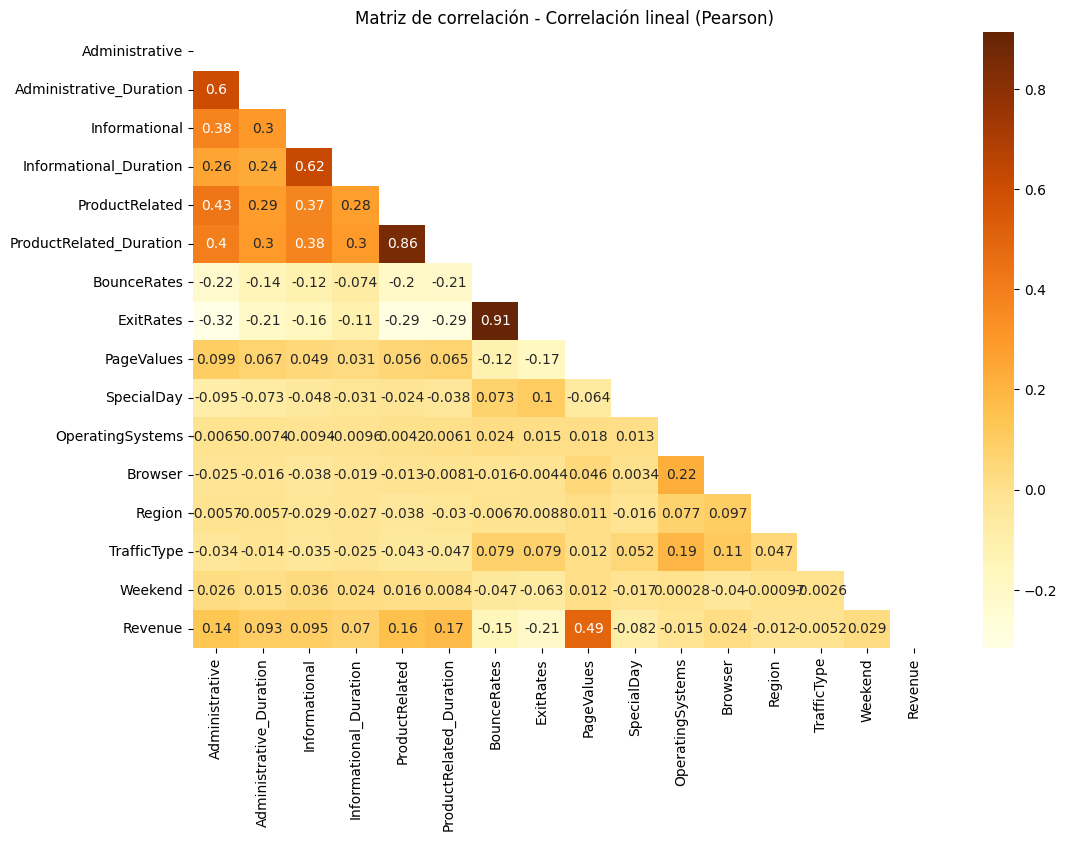

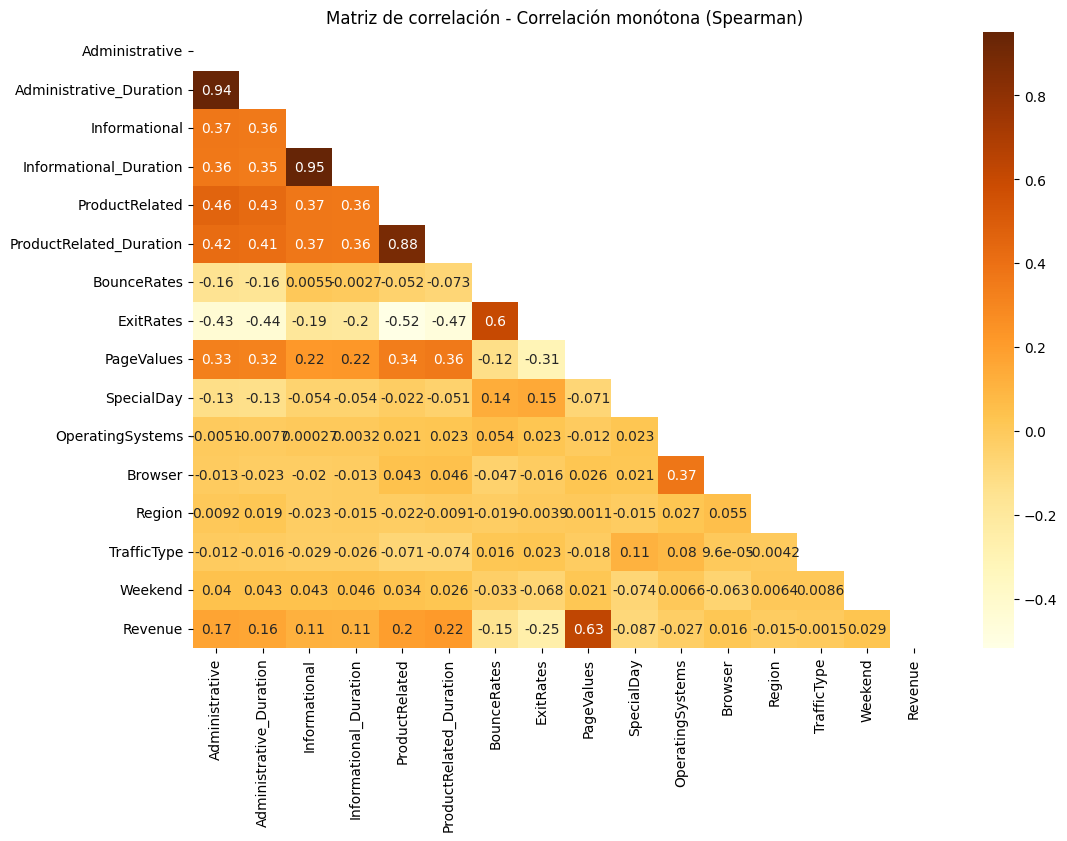

In [15]:
correlaciones_pearson = datos.corr(numeric_only=True, method='pearson')
mask = np.triu(np.ones_like(correlaciones_pearson, dtype=bool)) # Para recortar la matriz y dejar datos sin repetir.

plt.figure(figsize=(12,8))
sns.heatmap(correlaciones_pearson, annot=True, mask=mask, cmap='YlOrBr')
plt.title('Matriz de correlación - Correlación lineal (Pearson)')
plt.show()

correlaciones_spearman = datos.corr(numeric_only=True, method='spearman')
mask = np.triu(np.ones_like(correlaciones_spearman, dtype=bool)) # Para recortar la matriz y dejar datos sin repetir.

plt.figure(figsize=(12,8))
sns.heatmap(correlaciones_spearman, annot=True, mask=mask, cmap='YlOrBr')
plt.title('Matriz de correlación - Correlación monótona (Spearman)')
plt.show()

Observando las imágenes, podemos ver que las mayores correlaciones se producen entre los accesos a secciones específicas de la web y a la duración de la sesión en dichas páginas, lo cual es lógico.

También vemos una fuerte correlación lineal entre `Bounce Rates` y `Exit Rates`, lo cual también tiene sentido, puesto que para que la primera variable se contabilice, debe hacerse una salida de la web y en la mayoría de casos esto contabiliza también en la segunda variable.

En el caso de correlaciones no tan lineales (que pueden ser logarítmicas, exponenciales, etc.), vemos que las duraciones de las sesiones de `Administrative`, `Informational` y `Product Related` tienen una correlación muy fuerte entre ellas.

En el resto de las variables, hay mayor o menor correlación, pero no tan fuerte.

Ahora, realizamos gráficos de barras para comparar la variable target con otras variables, y ver en cada caso si se produjeron compras cuando cada variable tenía un mayor o menor valor:

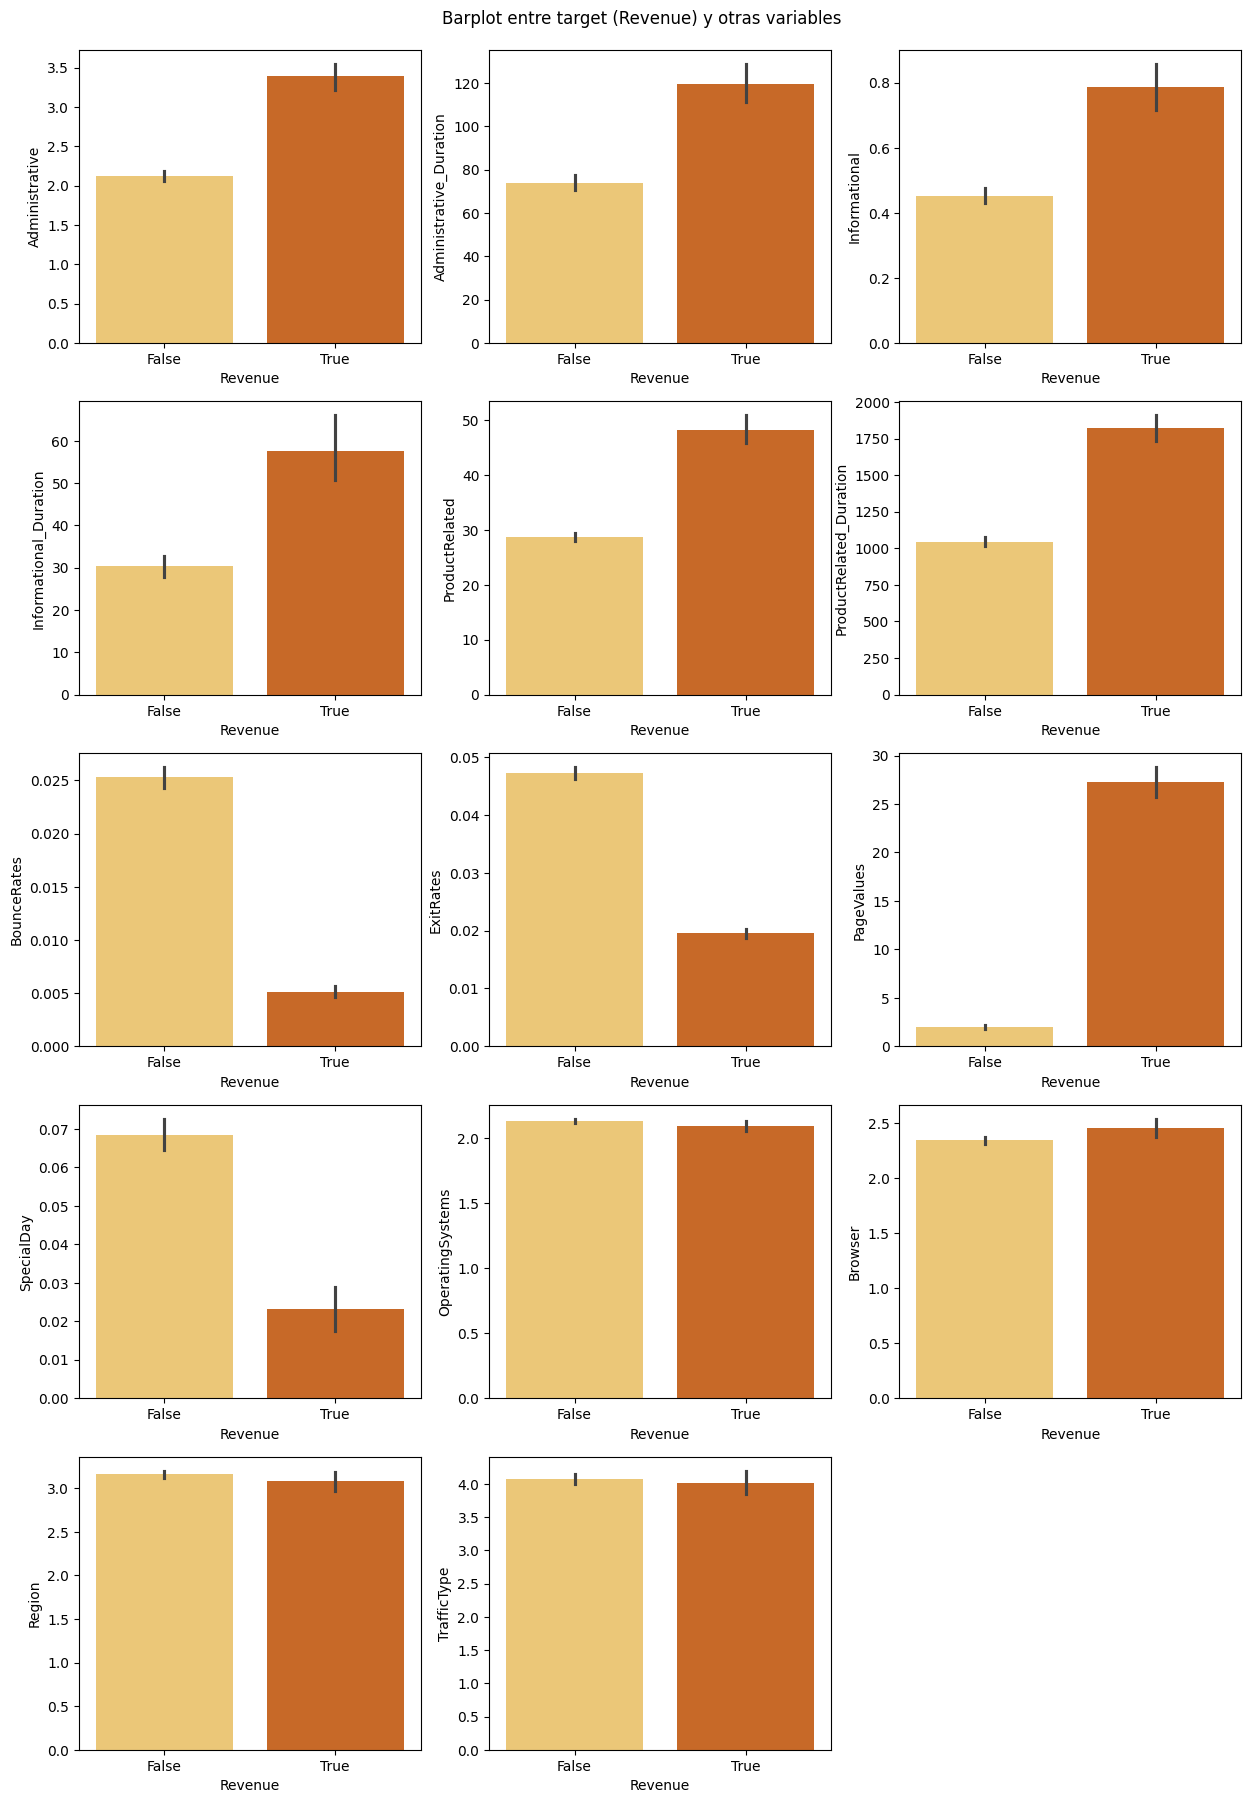

In [16]:
plt.figure(figsize=(15,20))
plt.suptitle('Barplot entre target (Revenue) y otras variables')

for i in range(len(columnas_numericas)):
    plt.subplot(5, 3, i+1)
    sns.barplot(datos, x='Revenue', y=columnas_numericas[i], hue='Revenue', palette='YlOrBr', legend=False)

plt.subplots_adjust(top=0.96)
plt.show()

Observando los gráficos, hay dos de ellos que muestran una mayor diferencia:

- En el caso de `Bounce Rates`, es lógico pensar que si un cliente entró en la web y salió sin activar ninguna otra solicitud, no compren, puesto que no se ha mostrado interés en la web.

- En el caso de `Pages Values`, es lógico pensar que, si un cliente ha visitado la página repetidamente, es porque le interesan los productos, y por tanto es normal que compre.

**Conclusiones del análisis descriptivo:**

- Hemos modificado los datos erróneos y procesado los nulos y valores atípicos.
- Hemos analizado las variables numéricas y categóricas, observando por ejemplo que se visita más la web en mayo.
- Hemos observado las correlaciones entre variables numéricas, detectando mayor correlación entre la sección visitada y su duración.
- Hemos detectado que existe una cierta relación entre las veces que se visita la página y la realización de compras, o que los clientes que salen sin realizar otras solicitudes no compran tanto.

## 2. Preprocesamiento de datos

Ahora, prepararemos los datos para poder pasarlos a los modelos que vamos a entrenar. Hasta ahora ya hemos corregido las inconsistencias, los nulos y algunos outliers.

Observando las variables que tenemos, las columnas de `Operating Systems`, `Browser` y `Region` tienen una **correlación lineal** muy cercana a 0 tanto con la variable target como con el resto de variables, y los boxplot anteriores muestran una distribución prácticamente igual de los datos entre un target positivo y uno negativo.

Aunque la correlación de Spearman nos indica que no hay correlaciones monótonas entre estas variables con otras numéricas ni con el target, puede existir una **correlación no lineal** que no estemos viendo con variables categóricas, por lo que, para asegurarnos, usaremos el **ratio de correlación (eta cuadrado)**, útil para detectar relaciones curvilíneas y así asegurarnos de que descartar estas variables no va a suponer perder información valiosa.

La fórmula es la siguiente:

$ \eta^2 = \frac{SSB}{SST} $

- $ SSB = \sum_{j=1}^{k} n_j(\bar{y}_j - \bar{y})^2 $

- $ SST = \sum_{i=1}^{n} (y_i - \bar{y})^2 $

El valor se encontrará entre 0 y 1, siendo cercano 0 que no se encuentra correlación; y cercano a 1, que tiene una correlación muy fuerte.

Para hacer los cálculos, usamos la función creada y definida al principio, y le pasamos todas las columnas para que compare entre ellas si existe alguna correlación no lineal:

In [17]:
variables_analizar = ['OperatingSystems', 'Browser', 'Region']

for columna_x in variables_analizar:
    for columna_y in datos.select_dtypes(include='number').drop(variables_analizar, axis=1):
        ratio_correlacion = calcular_ratio_correlacion(datos[columna_x], datos[columna_y])

        # Mostramos solo valores con ratio de correlación mayor a 0.01 para no saturar.
        if ratio_correlacion >= 0.01:
            print(f"Ratio de correlación (η²) entre {columna_x} y {columna_y}: {round(ratio_correlacion, 4)}")

print('Finalizado.')

Ratio de correlación (η²) entre OperatingSystems y ProductRelated: 0.0184
Ratio de correlación (η²) entre OperatingSystems y ProductRelated_Duration: 0.0195
Ratio de correlación (η²) entre OperatingSystems y BounceRates: 0.0224
Ratio de correlación (η²) entre OperatingSystems y ExitRates: 0.013
Ratio de correlación (η²) entre OperatingSystems y TrafficType: 0.0675
Ratio de correlación (η²) entre Region y TrafficType: 0.0135
Finalizado.


Como podemos observar, los ratios de correlación eta cuadrado son muy bajos (menos del 5% de la variabilidad de los datos se pueden explicar por estas variables), por lo que en este caso definitivamente las eliminaremos, ya que no nos aportan información útil y de esta manera reducimos la complejidad de los datos y hacemos más rápido y eficiente el modelado posterior.

Como tenemos dos columnas categóricas (`Month` y `Visitor Type`), tenemos que pasarlas a formato numérico. Como no tienen un orden específico (como podría darse por ejemplo con niveles de educación), las transformamos a dummies:

In [18]:
# Creamos una copia para usar en el modelo.
datos_modelo = datos.copy()

datos_modelo = pd.get_dummies(datos_modelo, drop_first=True)

Seleccionamos variables input y target.

Para las variables input, vamos a eliminar `Operating Systems`, `Browser` y `Region` por no haber encontrado relaciones con el target ni con otras variables; y `Administrative`, `Informational` y `Product Related` porque tienen una correlación muy fuerte (mayor de 0.85) con las variables respectivas de duración, por lo que mantener ambas sería redundante y haría el modelado menos eficiente. Lo mismo ocurre con `Bounce Rates` y `Exit Rates`, que también tienen una correlación muy fuerte entre ellas, por lo que dejamos solo una:

In [19]:
X = datos_modelo.drop(['OperatingSystems', 'Browser', 'Region',
                       'Administrative', 'Informational', 'ProductRelated',
                       'ExitRates', 'Revenue'], axis=1) # Variables input.
y = datos_modelo['Revenue'] # Variable target.

Dividimos los datos en conjuntos de entrenamiento y prueba:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Comprobamos el desbalanceo de datos:

In [21]:
y[y == True].count() / y.count()

np.float64(0.15492042871062034)

Como los datos están desbalanceados (15% de la clase True de `Revenue` frente al 85% de la clase False), realizaremos un oversampling, que consistirá en tomar más datos de la clase minoritaria para equipararlo a la clase mayoritaria. Para ello usaremos la librería RandomOverSampler.

También realizamos la estandarización de los datos. En este caso, como tenemos muchos outliers, en vez de usar `Standard Scaler`, usaremos `Robust Scaler`, que es más útil cuando los datos contienen gran cantidad de valores atípicos, ya que usa la mediana y el rango intercuartílico (que no son sensibles a los valores atípicos) para ajustarlos.

Estos dos pasos, para evitar fuga de datos entre los conjuntos de entrenamiento y test y hacer el procesamiento más limpio, los realizaremos con un pipeline, en el que aplicaremos, en orden, la estandarización, el oversampling y el modelo de ML/DL. Esto está definido en la función escrita anteriormente `definir_pipeline()`.

**Conclusiones del preprocesamiento:**

- Hemos eliminado las variables sin relación y las que tenían una fuerte correlación con otras.
- Hemos aplicado dummies en variables categóricas.
- Hemos dividido en conjunto de entrenamiento y prueba.
- Hemos preparado una estandarización y un oversampling a través de un pipeline.

## 3. Ajuste y evaluación de distintos modelos de clasificación

Una vez finalizado el preprocesamiento de los datos, entrenaremos y evaluaremos tres modelos de clasificación:
- KNN.
- XGBoost.
- Red neuronal MLP.

La métrica que usaremos para optimizar los hiperparámetros y evaluar cada modelo será el **AUC**, que indica el rendimiento de un modelo de clasificación y su capacidad para distinguir entre clases.

Para ajustar los hiperparámetros de cada modelo, usaremos la librería `Optuna`, que nos permite optimizar los hiperparámetros de forma eficiente y rápida. Para ello, definimos una función que toma como entrada el modelo y el conjunto de datos, y devuelve el AUC del modelo ajustado.

### 3.1. KNN

Comenzamos por KNN. Dentro de la función que le pasaremos a Optuna, escogemos cuántos vecinos queremos que pruebe, los pesos y las métricas de distancia. Después, creamos el pipeline con el modelo y los parámetros que deseamos probar, y lo ajustamos sobre los datos de entrenamiento. Finalmente, obtenemos la métrica del AUC:

In [22]:
def objective_knn(trial):
    # 1. Definir hiperparámetros.
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 25),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
    }

    # 2. Entrenar modelo con los hiperparámetros.
    pipeline_knn = definir_pipeline(KNeighborsClassifier(**params)) # Creamos pipeline y pasamos parámetros al modelo.
    pipeline_knn.fit(X_train, y_train) # Ajustamos pipeline sobre datos de entrenamiento.

    # 3. Obtener métrica.
    y_pred = pipeline_knn.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)

    return score

Ahora, usamos la función `objective_knn` con Optuna para optimizar los hiperparámetros:

In [23]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='maximize') # Maximizar el AUC.
study.optimize(objective_knn, n_trials=50) # Hacer 50 pruebas.

print('Mejor AUC:', round(study.best_value, 2))
print('Mejores hiperparámetros:', study.best_params)

Mejor AUC: 0.89
Mejores hiperparámetros: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan'}


Añadimos los hiperparámetros al modelo, dentro del pipeline:

In [24]:
knn = definir_pipeline(KNeighborsClassifier(**study.best_params))
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('oversampling', RandomOverSampler(random_state=0)),
                ('modelo',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=25,
                                      weights='distance'))])

In [25]:
predecir_evaluar_auc(knn, X_train, X_test, y_train, y_test)

Train: 1.0
Test: 0.89


Como podemos observar, el modelo tiene un buen resultado en test, pero está muy sobreajustado, ya que en train el valor es mucho más alto que el de test. Intentaremos ajustarlo para que generalice mejor. Modificamos los pesos y probamos con algunos vecinos más para reducir el sobreajuste:

In [26]:
knn = definir_pipeline(KNeighborsClassifier(n_neighbors=80, weights='uniform', metric='manhattan'))

knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('oversampling', RandomOverSampler(random_state=0)),
                ('modelo',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=80))])

In [27]:
predecir_evaluar_auc(knn, X_train, X_test, y_train, y_test)

Train: 0.92
Test: 0.91


El modelo generaliza mucho mejor, y hemos aumentado el AUC en test, por lo que nos quedamos con estos hiperparámetros.

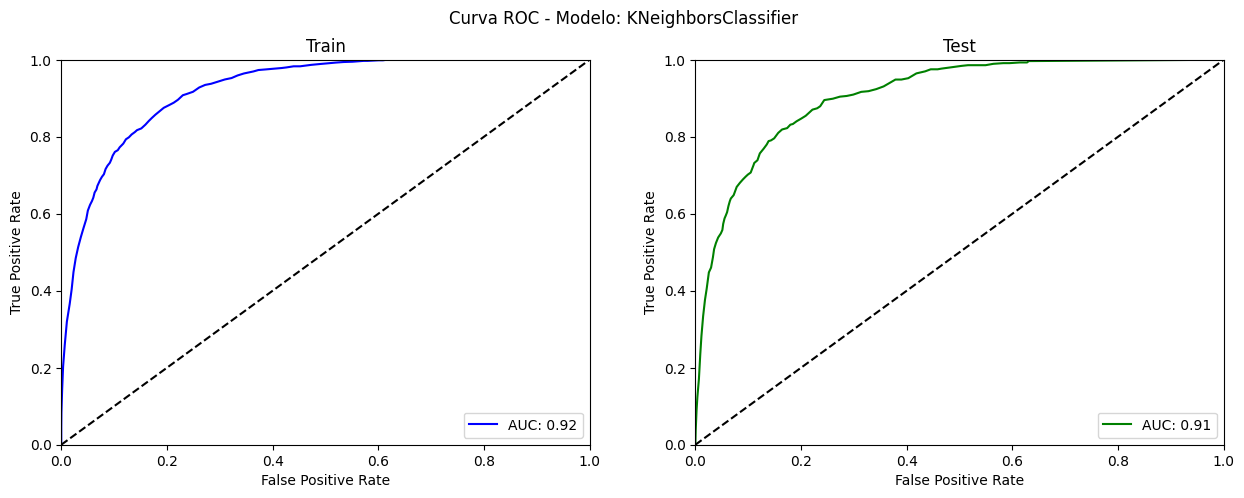

In [28]:
curva_roc(knn, X_train, X_test, y_train, y_test)

### 3.2. XGBoost

Dentro de los modelos basados en árboles de decisión, elegimos XGBoost, ya que es rápido y es capaz de capturar mejor la complejidad de los datos. Decidimos probar entre 3 y 10 de profundidad; 200, 300 o 400 estimadores; y un eta entre 0.1, 0.01 y 0.001:

In [29]:
def objective_xgboost(trial):
    # 1. Definir hiperparámetros.
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_categorical('n_estimators', [200, 300, 400]),
        'eta': trial.suggest_categorical('eta', [0.1, 0.01, 0.001])
    }

    # 2. Entrenar modelo con los hiperparámetros.
    pipeline_xgboost = definir_pipeline(XGBClassifier(**params)) # Creamos pipeline y pasamos parámetros al modelo.
    pipeline_xgboost.fit(X_train, y_train) # Ajustamos pipeline sobre datos de entrenamiento.

    # 3. Obtener métrica.
    y_pred = pipeline_xgboost.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)

    return score

Pasamos la función a Optuna:

In [30]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=50)

print('Mejor AUC:', round(study.best_value, 2))
print('Mejores hiperparámetros:', study.best_params)

Mejor AUC: 0.93
Mejores hiperparámetros: {'max_depth': 4, 'n_estimators': 400, 'eta': 0.01}


Añadimos los hiperparámetros seleccionados al modelo del pipeline y ajustamos en conjunto de entrenamiento:

In [31]:
xgboost = definir_pipeline(XGBClassifier(**study.best_params))

xgboost.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('oversampling', RandomOverSampler(random_state=0)),
                ('modelo',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.01,
                               eval_metric=None, feature_types=None,
                               feature_weights=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None, ...))])

In [32]:
predecir_evaluar_auc(xgboost, X_train, X_test, y_train, y_test)

Train: 0.94
Test: 0.93


Como podemos observar, los valores del AUC son muy similares. Hay un ligero sobreajuste, así que probamos a cambiar los parámetros para reducirlo. En este caso, disminuimos el eta y los estimadores:

In [33]:
xgboost = definir_pipeline(XGBClassifier(eta=0.001, max_depth=4, n_estimators=300))

xgboost.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('oversampling', RandomOverSampler(random_state=0)),
                ('modelo',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.001,
                               eval_metric=None, feature_types=None,
                               feature_weights=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None, ...))])

In [34]:
predecir_evaluar_auc(xgboost, X_train, X_test, y_train, y_test)

Train: 0.93
Test: 0.93


Tras ajustar manualmente los parámetros, hemos conseguido mantener el AUC de test, reduciendo el sobreajuste en train, igualándolo. De esta forma obtenemos un modelo que generaliza mucho mejor.

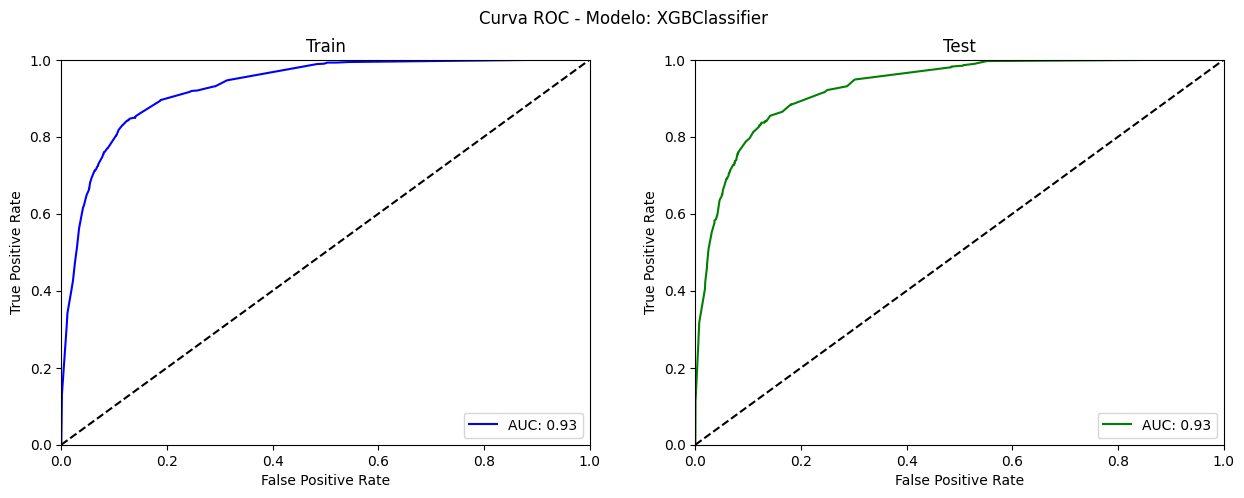

In [35]:
curva_roc(xgboost, X_train, X_test, y_train, y_test)

En este caso, podemos ver también la importancia que le da el modelo a cada una de las variables, lo cual lo hace un poco más interpretable dsede una perspectiva de negocio:

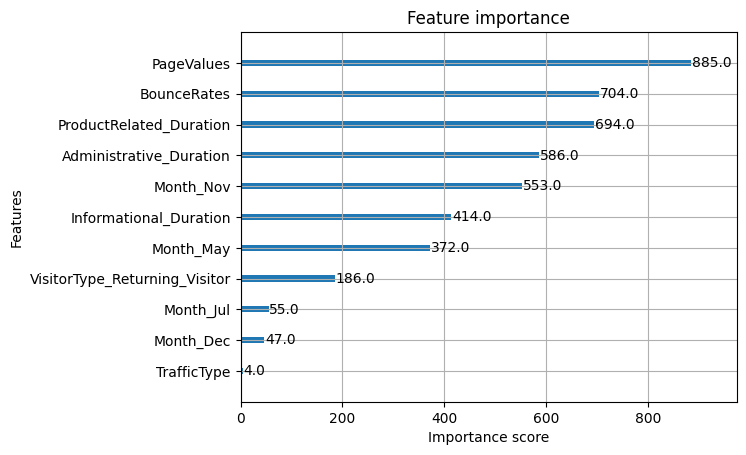

In [36]:
xgboost.named_steps['modelo'].get_booster().feature_names = list(X.columns) # Obtenemos nombres de columnas.

plot_importance(xgboost.named_steps['modelo']) # Mostramos importancia de cada columna.
plt.show()

Como podemos observar, el modelo da la mayor importancia a `Page Values` y a `Bounce Rates` y `Product Related Duration`, es decir, que considera más importante la cantidad de veces que el cliente visita la web y el tiempo que pasa en la sección de productos de cara a realizar una compra, así como si sale sin realizar ninguna acción.

### 3.3. Red neuronal MLP

Pasando a la parte de la red neuronal MLP, para conocer el número de neuronas para colocar en la capa oculta, utilizamos las siguientes reglas empíricas que se han ido desarrollando en base a la práctica:

In [37]:
print('Número de neuronas recomendadas:', round(np.sqrt(len(X.columns)*2)))
print('Número de neuronas recomendadas:', round(2/3 * len(X.columns) + 2))

Número de neuronas recomendadas: 6
Número de neuronas recomendadas: 15


Vamos a usar Optuna de nuevo para ajustar los parámetros.
Decidimos probar con dos capas ocultas (15 y 6 neuronas), o con una sola capa con 15 o con 6 neuronas. Ajustamos el parámetro de activación para elegir entre logistic y relu; y el número de épocas a elegir entre 600, 800 y 1000:

In [38]:
def objective_mlp(trial):
    # 1. Definir hiperparámetros.
    params = {
        'max_iter': trial.suggest_categorical('max_iter', [600, 800, 1000]),
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(15,6), (15,), (6,)]),
        'activation': trial.suggest_categorical('activation', ['logistic', 'relu']),
        'random_state': trial.suggest_categorical('random_state', [0])
    }

    # 2. Entrenar modelo con los hiperparámetros.
    pipeline_mlp = definir_pipeline(MLPClassifier(**params)) # Creamos pipeline y pasamos parámetros al modelo.
    pipeline_mlp.fit(X_train, y_train) # Ajustamos pipeline sobre datos de entrenamiento.

    # 3. Obtener métrica.
    y_pred = pipeline_mlp.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)

    return score

Optimizamos con Optuna. En este caso, como estamos pasando una lista de tuplas en la sección de `suggest_categorical`, Optuna da avisos constantes porque espera una lista de números o strings, pero lo aplica correctamente de todas formas. También surgen avisos de convergencia, cuando el modelo no llega a valores óptimos (ocurre si se usan solo 600 epochs). Por ello, silenciamos los avisos:

In [39]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore", message="Choices for a categorical distribution") # Avisos revisados que no son útiles.
warnings.filterwarnings("ignore", category=ConvergenceWarning)
study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp, n_trials=50)

print('Mejor AUC:', round(study.best_value, 2))
print('Mejores hiperparámetros:', study.best_params)

Mejor AUC: 0.93
Mejores hiperparámetros: {'max_iter': 600, 'hidden_layer_sizes': (6,), 'activation': 'logistic', 'random_state': 0}


Aplicamos los hiperparámetros seleccionados en el modelo del pipeline:

In [40]:
mlp = definir_pipeline(MLPClassifier(**study.best_params))

mlp.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('oversampling', RandomOverSampler(random_state=0)),
                ('modelo',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=(6,),
                               max_iter=600, random_state=0))])

In [41]:
predecir_evaluar_auc(mlp, X_train, X_test, y_train, y_test)

Train: 0.93
Test: 0.93


En este caso, con los parámetros que se han indicado, el modelo está muy bien ajustado. El AUC tiene un valor alto y no se observa sobreajuste, por lo que nos quedamos directamente con estos hiperparámetros.

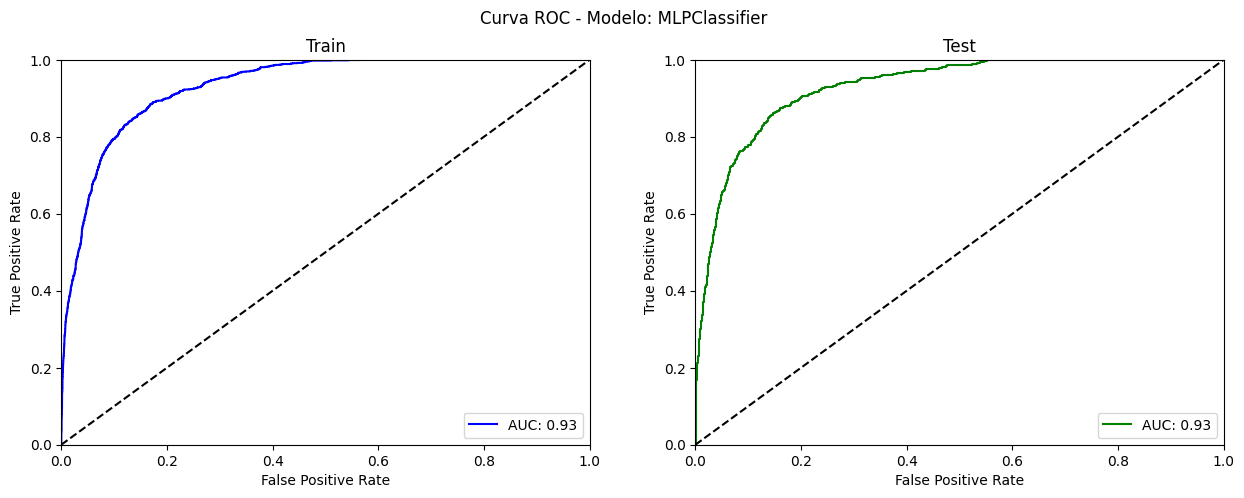

In [42]:
curva_roc(mlp, X_train, X_test, y_train, y_test)

## 4. Métricas sobre el modelo elegido

En base a los modelos entrenados, los dos modelos que tienen mejor AUC son XGBoost y MLP, que tienen un 0.93 de AUC.

De cara a las métricas, el recall nos dirá cuántos positivos reales se detectaron; la precisión, cuántos positivos son reales respecto a todos los clasificados como positivos; accuracy, el porcentaje de aciertos entre todos los casos; y el F1, la media balanceada entre precisión y recall.

Probamos diferentes umbrales para cada uno de estos dos modelos para ver cuál obtiene mejores métricas en general con un menor umbral de probabilidad. Como se nos pide que la precisión y el recall sean lo más similares posible, lo ajustamos en base a ello:

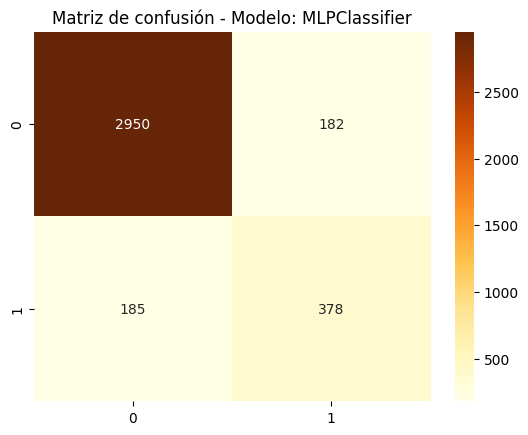

MÉTRICAS:
    - Recall: 0.67
    - Precisión: 0.68
    - Accuracy: 0.9
    - F1: 0.67
    


In [43]:
umbral_metricas(mlp, 0.8, X_test, y_test)

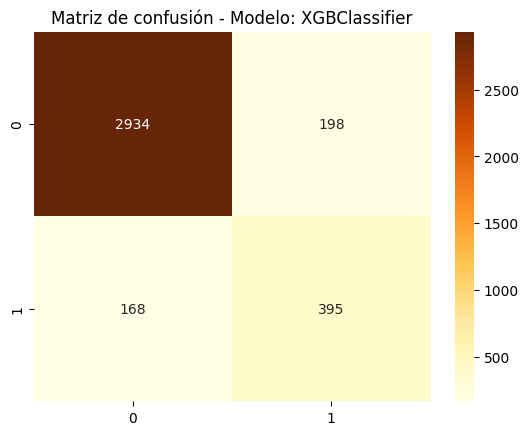

MÉTRICAS:
    - Recall: 0.7
    - Precisión: 0.67
    - Accuracy: 0.9
    - F1: 0.68
    


In [44]:
umbral_metricas(xgboost, 0.57, X_test, y_test)

Observando ambos modelos, nos quedaremos con **XGBoost**:
- Con un menor umbral (57%), obtenemos incluso mejores métricas.
- Nos indica que, en base al umbral escogido, es capaz de acertar en el 90% de casos, y que puede detectar con un 67% de acierto si un cliente comprará.
- Tiene una mejor interpretabilidad.

En base a este modelo, mostramos la curva de ganancia acumulada:

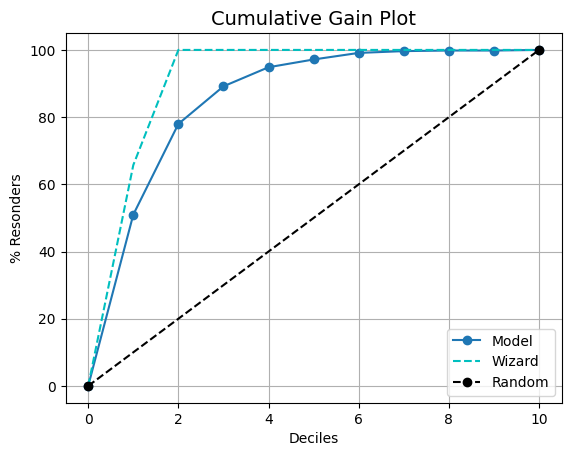

In [45]:
y_pred = xgboost.predict_proba(X_test)[:,1]
plot_cumulative_gain(y_test, y_pred)

La gráfica nos indica el porcentaje de compradores que el modelo es capaz de detectar respecto a una selección aleatoria. Observando la gráfica, podemos afirmar que este modelo permite capturar casi el **80% de los compradores reales contactando solo al 20%** de todos los visitantes de la web. Este rendimiento es muy superior comparado con realizar una búsqueda aleatoria, en la cual, contactando al mismo porcentaje, solo podríamos capturar el 20% de los compradores.

Finalmente, podemos exportar el pipeline con el modelo a formato pickle para poder aplicarse en datos reales:

In [46]:
pickle.dump(xgboost, open('./modelos/modelo_final.pkl', 'wb'))